In [1]:
import pandas as pd
from pandas.plotting import table
import seaborn as sns
import pm4py
from ImageExporter import df_image_exporter
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pm4py.objects.log.util import interval_lifecycle
from ImageExporter.df_image_exporter import create_image

## Pre-processing of Data

In [13]:
# Reading xes file
## log = pm4py.read_xes('BPI Challenge 2017.xes')

parsing log, completed traces :: 100%|██████████| 31509/31509 [00:30<00:00, 1023.35it/s]


In [73]:
# Load the log from .pkl file
file_name = "data/data_log.pkl"
log = 0
with open(file_name, "rb") as f:
    log = pickle.load(f)


In [3]:
# convert to dataframe
log_copy = log.copy()
df = pm4py.convert_to_dataframe(log_copy)

# Change of column names for simplicity
df.rename(columns={'case:concept:name' : 'caseID', 'concept:name' : 'taskID', 'org:resource' : 'originator',
                   'lifecycle:transition' : 'EventType', 'case:LoanGoal' : 'LoanGoal', 'case:RequestedAmount' : 'RequestedAmount', 'case:ApplicationType' : 'ApplicationType', 'time:timestamp' : 'Timestamp'}, inplace=True)

# Rename the caseID to A1, A2, A3, ... etc
unique_cases = df['caseID'].unique()
new_ids = [f'A{i+1}' for i in range(len(unique_cases))]
case_map = dict(zip(unique_cases, new_ids))
df['caseID'] = df['caseID'].map(case_map)

#df.to_csv("data/data_log.csv", index=False)
df

Action originator                  taskID  EventOrigin  \
0            Created     User_1    A_Create Application  Application   
1        statechange     User_1             A_Submitted  Application   
2            Created     User_1          W_Handle leads     Workflow   
3            Deleted     User_1          W_Handle leads     Workflow   
4            Created     User_1  W_Complete application     Workflow   
...              ...        ...                     ...          ...   
1202262      Deleted     User_1     W_Call after offers     Workflow   
1202263      Created     User_1     W_Call after offers     Workflow   
1202264  statechange    User_28             A_Cancelled  Application   
1202265  statechange    User_28             O_Cancelled        Offer   
1202266      Deleted    User_28     W_Call after offers     Workflow   

                       EventID  EventType                        Timestamp  \
0        Application_652823628   complete 2016-01-01 09:51:15.304000+00:00   
1         ApplState_1582051990   complete 2016-01-01 09:51:15.352000+00:00   
2          Workitem_1298499574   schedule 2016-01-01 09:51:15.774000+00:00   
3          Workitem_1673366067   withdraw 2016-01-01 09:52:36.392000+00:00   
4          Workitem_1493664571   schedule 2016-01-01 09:52:36.403000+00:00   
...                        ...        ...                              ...   
1202262    Workitem_1817549786  ate_abort 2017-01-06 06:33:02.212000+00:00   
1202263     Workitem_363876066   schedule 2017-01-06 06:33:02.221000+00:00   
1202264   ApplState_1869071797   complete 2017-01-16 09:51:21.114000+00:00   
1202265   OfferState_420066181   complete 2017-01-16 09:51:21.139000+00:00   
1202266    Workitem_1934044935   withdraw 2017-01-16 09:51:21.146000+00:00   

                       LoanGoal ApplicationType  caseID  RequestedAmount  \
0        Existing loan takeover      New credit      A1          20000.0   
1        Existing loan takeover      New credit      A1          20000.0   
2        Existing loan takeover      New credit      A1          20000.0   
3        Existing loan takeover      New credit      A1          20000.0   
4        Existing loan takeover      New credit      A1          20000.0   
...                         ...             ...     ...              ...   
1202262        Home improvement      New credit  A31509          20000.0   
1202263        Home improvement      New credit  A31509          20000.0   
1202264        Home improvement      New credit  A31509          20000.0   
1202265        Home improvement      New credit  A31509          20000.0   
1202266        Home improvement      New credit  A31509          20000.0   

         FirstWithdrawalAmount  NumberOfTerms Accepted  MonthlyCost Selected  \
0                          NaN            NaN      NaN          NaN      NaN   
1                          NaN            NaN      NaN          NaN      NaN   
2                          NaN            NaN      NaN          NaN      NaN   
3                          NaN            NaN      NaN          NaN      NaN   
4                          NaN            NaN      NaN          NaN      NaN   
...                        ...            ...      ...          ...      ...   
1202262                    NaN            NaN      NaN          NaN      NaN   
1202263                    NaN            NaN      NaN          NaN      NaN   
1202264                    NaN            NaN      NaN          NaN      NaN   
1202265                    NaN            NaN      NaN          NaN      NaN   
1202266                    NaN            NaN      NaN          NaN      NaN   

         CreditScore  OfferedAmount           OfferID  
0                NaN            NaN               NaN  
1                NaN            NaN               NaN  
2                NaN            NaN               NaN  
3                NaN            NaN               NaN  
4                NaN            NaN               NaN  
..

## Exploratory analysis

In [86]:
#checking the number of categories in column action
countAction = df['Action'].value_counts().reset_index(name='count')
print("This are the number of actions available:")
countAction

This are the number of actions available:


Action   count
0  statechange  358940
1     Obtained  255387
2      Created  223608
3     Released  215402
4      Deleted  148930

In [87]:
count_taskID = df['taskID'].value_counts().reset_index(name='count')
print("This are the number of tasks available:")
count_taskID

This are the number of tasks available:


taskID   count
0       W_Validate application  209496
1          W_Call after offers  191092
2      W_Call incomplete files  168529
3       W_Complete application  148900
4               W_Handle leads   47264
5               O_Create Offer   42995
6                    O_Created   42995
7     O_Sent (mail and online)   39707
8                 A_Validating   38816
9                   A_Accepted   31509
10        A_Create Application   31509
11                   A_Concept   31509
12                  A_Complete   31362
13                  O_Returned   23305
14                A_Incomplete   23055
15                 O_Cancelled   20898
16                 A_Submitted   20423
17                  O_Accepted   17228
18                   A_Pending   17228
19                 A_Cancelled   10431
20                   O_Refused    4695
21                    A_Denied    3753
22    W_Assess potential fraud    3282
23        O_Sent (online only)    2026
24     W_Shortened completion      238
25  W_Personal Loan collection      22

In [67]:
# number of EventOrigins
count_eventOrigins = df['EventOrigin'].value_counts().reset_index(name='count')
print("This are the number of events origins available:")
count_eventOrigins

This are the number of events origins available:


EventOrigin   count
0     Workflow  768823
1  Application  239595
2        Offer  193849

<Axes: ylabel='count'>

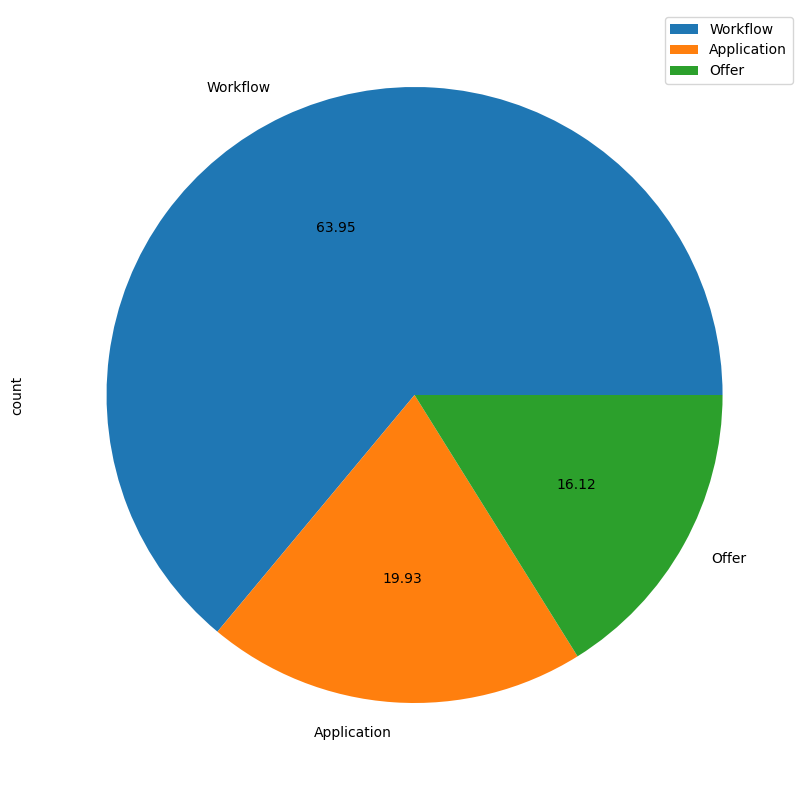

In [75]:
count_eventOrigins.plot.pie(labels=["Workflow", "Application", "Offer"], y='count', autopct="%.2f", figsize=(10,10))


In [47]:
''# number of eventType
count_eventType = df['EventType'].value_counts().reset_index(name='count')
print("This are the number of events type available:")
count_eventType

This are the number of events type available:


EventType   count
0   complete  475306
1    suspend  215402
2   schedule  149104
3      start  128227
4     resume  127160
5  ate_abort   85224
6   withdraw   21844

In [190]:
# number of ApplicationType
count_appType = df['ApplicationType'].value_counts().reset_index(name='count')
print("This are the ApplicationTypes available:")
count_appType

This are the number of ApplicationTypes available:


ApplicationType    count
0      New credit  1083767
1     Limit raise   118500

In [50]:
# calculate the lenght of each case
length_of_case = df.groupby('caseID')['caseID'].value_counts().reset_index(name='count')
length_of_case

mean_of_caseLength = length_of_case['count'].mean()
sd_of_caseLength = length_of_case['count'].std()

print("The mean of case length is: %2.f" % mean_of_caseLength)
print("The standard deviation of case length is: %2.f" % sd_of_caseLength)

The mean of case length is: 38
The standard deviation of case length is: 17


In [52]:
unique_count_loanGoal = df.groupby('caseID')['LoanGoal'].value_counts().reset_index(name='count')
count_of_uniq_loangoal = unique_count_loanGoal['LoanGoal'].value_counts().reset_index(name='count')
count_of_uniq_loangoal.index = count_of_uniq_loangoal.index + 1
df_image_exporter.create_image(count_of_uniq_loangoal, "Loan goals table.png")
count_of_uniq_loangoal


LoanGoal  count
1                      Car   9328
2         Home improvement   7669
3   Existing loan takeover   5601
4   Other, see explanation   2985
5                  Unknown   2365
6            Not speficied   1065
7      Remaining debt home    842
8     Extra spending limit    625
9         Caravan / Camper    369
10              Motorcycle    275
11                    Boat    201
12            Tax payments    152
13           Business goal     30
14      Debt restructuring      2

<Axes: ylabel='LoanGoal'>

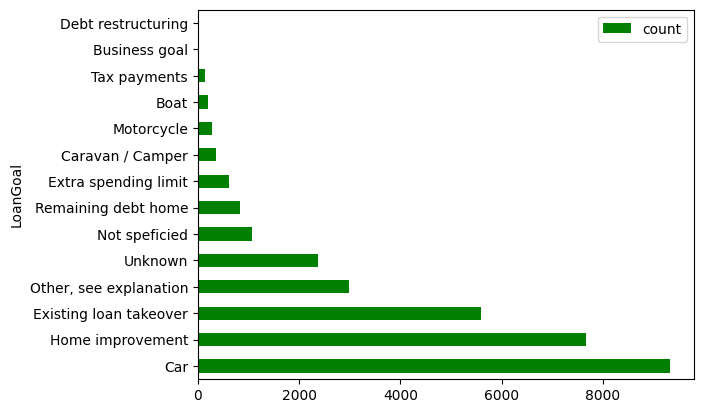

In [20]:
# Bar chart of loanGoals
count_of_uniq_loangoal.plot.barh(x='LoanGoal', y='count', color='green', rot=0)

### Calculating durations of each event

In [27]:
df['Timestamp'] = pd.to_datetime((df['Timestamp']))

In [35]:
# sort data
df_with_duration = df.copy()

df_with_duration = df_with_duration.sort_values(by=['caseID', 'Timestamp'])

df_with_duration['end_timestamp'] = df_with_duration.groupby('caseID')['Timestamp'].shift(-1)

df_with_duration['duration'] = df_with_duration['end_timestamp'] - df_with_duration['Timestamp']

df_with_duration['durationSeconds'] = df_with_duration['duration'].dt.total_seconds()

df_with_duration.head(10)


Action originator                  taskID  EventOrigin  \
0      Created     User_1    A_Create Application  Application   
1  statechange     User_1             A_Submitted  Application   
2      Created     User_1          W_Handle leads     Workflow   
3      Deleted     User_1          W_Handle leads     Workflow   
4      Created     User_1  W_Complete application     Workflow   
5  statechange     User_1               A_Concept  Application   
6     Obtained    User_17  W_Complete application     Workflow   
7     Released    User_17  W_Complete application     Workflow   
8  statechange    User_52              A_Accepted  Application   
9      Created    User_52          O_Create Offer        Offer   

                 EventID EventType                        Timestamp  \
0  Application_652823628  complete 2016-01-01 09:51:15.304000+00:00   
1   ApplState_1582051990  complete 2016-01-01 09:51:15.352000+00:00   
2    Workitem_1298499574  schedule 2016-01-01 09:51:15.774000+00:00   
3    Workitem_1673366067  withdraw 2016-01-01 09:52:36.392000+00:00   
4    Workitem_1493664571  schedule 2016-01-01 09:52:36.403000+00:00   
5    ApplState_642383566  complete 2016-01-01 09:52:36.413000+00:00   
6    Workitem_1875340971     start 2016-01-02 10:45:22.429000+00:00   
7    Workitem_1452291795   suspend 2016-01-02 10:49:28.816000+00:00   
8     ApplState_99568828  complete 2016-01-02 11:23:04.299000+00:00   
9        Offer_148581083  complete 2016-01-02 11:29:03.994000+00:00   

                 LoanGoal ApplicationType caseID  ...  NumberOfTerms  \
0  Existing loan takeover      New credit     A1  ...            NaN   
1  Existing loan takeover      New credit     A1  ...            NaN   
2  Existing loan takeover      New credit     A1  ...            NaN   
3  Existing loan takeover      New credit     A1  ...            NaN   
4  Existing loan takeover      New credit     A1  ...            NaN   
5  Existing loan takeover      New credit     A1  ...            NaN   
6  Existing loan takeover      New credit     A1  ...            NaN   
7  Existing loan takeover      New credit     A1  ...            NaN   
8  Existing loan takeover      New credit     A1  ...            NaN   
9  Existing loan takeover      New credit     A1  ...           44.0   

   Accepted  MonthlyCost Selected  CreditScore OfferedAmount  OfferID  \
0       NaN          NaN      NaN          NaN           NaN      NaN   
1       NaN          NaN      NaN          NaN           NaN      NaN   
2       NaN          NaN      NaN          NaN           NaN      NaN   
3       NaN          NaN      NaN          NaN           NaN      NaN   
4       NaN          NaN      NaN          NaN           NaN      NaN   
5       NaN          NaN      NaN          NaN           NaN      NaN   
6       NaN          NaN      NaN          NaN           NaN      NaN   
7       NaN          NaN      NaN          NaN           NaN      NaN   
8       NaN          NaN      NaN          NaN           NaN      NaN   
9      True       498.29     True        979.0       20000.0      NaN   

                     end_timestamp               duration durationSeconds  
0 2016-01-01 09:51:15.352000+00:00 0 days 00:00:00.048000           0.048  
1 2016-01-01 09:51:15.774000+00:00 0 days 00:00:00.422000           0.422  
2 2016-01-01 09:52:36.392000+00:00 0 days 00:01:20.618000          80.618  
3 2016-01-01 09:52:36.403000+00:00 0 days 00:00:00.011000           0.011  
4 2016-01-01 09:52:36.413000+00:00 0 days 00:00:00.010000           0.010  
5 2016-01-02 10:45:22.429000+00:00 1 days 00:52:46.016000       89566.016  
6 2016-01-02 10:49:28.816000+00:00 0 days 00:04:06.387000         246.387  
7 2016-01-02 11:23:04.299000+00:00 0 days 00:33:35.483000        2015.483  
8 2016-01-02 11:29:03.994000+00:00 0 days 00:05:59.695000         359.695  
9 2016-01-02 11:29:05.354000+00:00 0 days 00:00:01.360000           1.360  

[10 rows x 22 columns]

In [41]:
case_duration_table = df_with_duration.groupby('caseID')['Timestamp'].agg(['min', 'max'])
case_duration_table['totalDuration'] = case_duration_table['max'] - case_duration_table['min']

case_duration_table['totalDuration_seconds'] = case_duration_table['totalDuration'].dt.total_seconds()
case_duration_table['totalDuration_hours'] = case_duration_table['totalDuration'].dt.total_seconds() / 3600

case_duration_table.head(10)

min                              max  \
caseID                                                                     
A1     2016-01-01 09:51:15.304000+00:00 2016-01-14 15:49:11.423000+00:00   
A10    2016-01-01 14:23:21.334000+00:00 2016-02-02 07:00:34.765000+00:00   
A100   2016-01-03 20:32:05.061000+00:00 2016-01-14 14:50:51.864000+00:00   
A1000  2016-01-15 08:19:57.758000+00:00 2016-01-26 10:43:14.819000+00:00   
A10000 2016-05-12 07:24:03.925000+00:00 2016-06-14 11:46:23.456000+00:00   
...                                 ...                              ...   
A9995  2016-05-11 21:56:40.803000+00:00 2016-07-12 10:46:12.402000+00:00   
A9996  2016-05-11 22:40:09.134000+00:00 2016-06-07 10:36:23.665000+00:00   
A9997  2016-05-12 07:06:33.049000+00:00 2016-05-23 12:54:38.358000+00:00   
A9998  2016-05-12 07:07:44.674000+00:00 2016-06-06 10:24:34.993000+00:00   
A9999  2016-05-12 07:21:31.389000+00:00 2016-06-24 11:52:58.716000+00:00   

                 totalDuration  totalDuration_seconds  totalDuration_hours  
caseID                                                                      
A1     13 days 05:57:56.119000            1144676.119           317.965589  
A10    31 days 16:37:13.431000            2738233.431           760.620397  
A100   10 days 18:18:46.803000             929926.803           258.313001  
A1000  11 days 02:23:17.061000             958997.061           266.388073  
A10000 33 days 04:22:19.531000            2866939.531           796.372092  
...                        ...                    ...                  ...  
A9995  61 days 12:49:31.599000            5316571.599          1476.825444  
A9996  26 days 11:56:14.531000            2289374.531           635.937370  
A9997  11 days 05:48:05.309000             971285.309           269.801475  
A9998  25 days 03:16:50.319000            2171810.319           603.280644  
A9999  43 days 04:31:27.327000            3731487.327          1036.524257  

[31509 rows x 5 columns]

In [61]:
mean_case_duration = case_duration_table['totalDuration_hours'].mean()
sd_case_duration = case_duration_table['totalDuration_hours'].std()

print("The mean of case duration(hours) is: %.2f and in days: %.2f" % (mean_case_duration, mean_case_duration/24))
print("The standard deviation of case duration(hours) is: %.2f and in days: %.2f" % (sd_case_duration, sd_case_duration/24))

The mean of case duration(hours) is: 525.59 and in days: 21.90
The standard deviation of case duration(hours) is: 316.06 and in days: 13.17


### Plotting distribution of LoanGoals

In [34]:
# Assuming df_counts is your DataFrame
threshold = 150

# Create a new DataFrame for plotting
df_plot = count_of_uniq_loangoal.copy()

# Find all categories *below* the threshold and change their 'LoanGoal' to 'Other' -> 'Business Goal' and 'Debt restructuring'
df_plot.loc[df_plot['count'] < threshold, 'LoanGoal'] = 'Other'

# Now, group by the new 'LoanGoal' and sum the counts
df_plot_grouped = df_plot.groupby('LoanGoal')['count'].sum().reset_index()

# Sort for plotting
df_plot_grouped = df_plot_grouped.sort_values(by='count', ascending=False)

C:\Users\kickb\AppData\Local\Temp\ipykernel_9144\3114017387.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


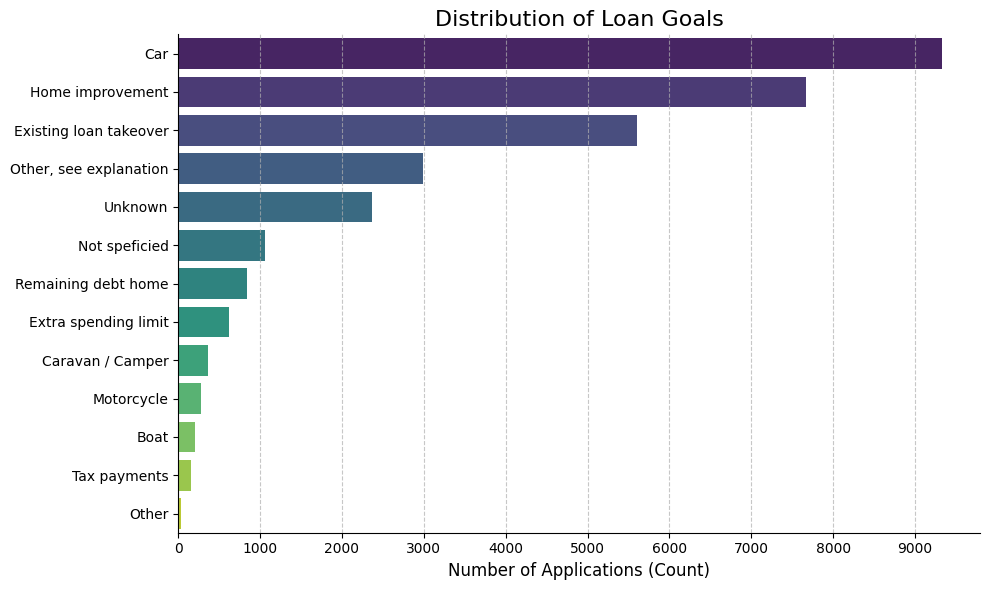

In [40]:
plt.figure(figsize=(10, 6))  # Can be a bit smaller now

ax = sns.barplot(
    x='count',
    y='LoanGoal',
    data=df_plot_grouped,
    palette='viridis'
)

plt.title('Distribution of Loan Goals', fontsize=16)
plt.xlabel('Number of Applications (Count)', fontsize=12)
plt.ylabel('')
sns.despine()

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
ax.grid(True, axis='x', linestyle='--', alpha=0.7, zorder=0)

plt.tight_layout()
plt.show()

In [21]:
# Calculation of the avarage of event logs per related to a user
number_of_users = 31509
total_rows = len(df)
avg_logs_per_application = total_rows / number_of_users
print("The average number of event logs generated by an application/case: %.2f" % avg_logs_per_application)

The average number of event logs generated by an application/case: 38.16


In [61]:
# Number of single applications
number_of_applications = df['caseID'].nunique()
print("Number of total applications: %d" % number_of_applications)

Number of total applications: 31509


In [90]:
# Analyzing one single application (Application_652823628)
logs_for_one_application = df[df['caseID'] == "A5"]
logs_for_one_application

Action originator                    taskID  EventOrigin  \
200      Created     User_1      A_Create Application  Application   
201  statechange     User_1               A_Submitted  Application   
202      Created     User_1            W_Handle leads     Workflow   
203      Deleted     User_1            W_Handle leads     Workflow   
204      Created     User_1    W_Complete application     Workflow   
205  statechange     User_1                 A_Concept  Application   
206     Obtained    User_19    W_Complete application     Workflow   
207  statechange    User_19                A_Accepted  Application   
208      Created    User_19            O_Create Offer        Offer   
209  statechange    User_19                 O_Created        Offer   
210  statechange    User_19  O_Sent (mail and online)        Offer   
211      Deleted    User_19    W_Complete application     Workflow   
212      Created    User_19       W_Call after offers     Workflow   
213     Obtained    User_19       W_Call after offers     Workflow   
214  statechange    User_19                A_Complete  Application   
215     Released    User_19       W_Call after offers     Workflow   
216     Obtained    User_11       W_Call after offers     Workflow   
217     Released    User_11       W_Call after offers     Workflow   
218  statechange     User_1               A_Cancelled  Application   
219  statechange     User_1               O_Cancelled        Offer   
220      Deleted     User_1       W_Call after offers     Workflow   

                   EventID  EventType                        Timestamp  \
200  Application_828200680   complete 2016-01-01 13:00:04.360000+00:00   
201    ApplState_420123528   complete 2016-01-01 13:00:04.398000+00:00   
202    Workitem_1645277487   schedule 2016-01-01 13:00:04.737000+00:00   
203    Workitem_1902399339   withdraw 2016-01-01 13:01:44.651000+00:00   
204    Workitem_1933317539   schedule 2016-01-01 13:01:44.661000+00:00   
205    ApplState_281446729   complete 2016-01-01 13:01:44.671000+00:00   
206    Workitem_1987035323      start 2016-01-02 11:32:57.796000+00:00   
207    ApplState_873422308   complete 2016-01-02 11:40:45.797000+00:00   
208        Offer_607758096   complete 2016-01-02 11:42:23.751000+00:00   
209   OfferState_328204955   complete 2016-01-02 11:42:25.106000+00:00   
210  OfferState_1161306540   complete 2016-01-02 11:43:56.242000+00:00   
211     Workitem_975111658   complete 2016-01-02 11:43:56.259000+00:00   
212    Workitem_1704827982   schedule 2016-01-02 11:43:56.266000+00:00   
213    Workitem_1894841035      start 2016-01-02 11:43:56.269000+00:00   
214   ApplState_2090693037   complete 2016-01-02 11:43:56.271000+00:00   
215     Workitem_249716911    suspend 2016-01-02 11:46:13.901000+00:00   
216     Workitem_994377855     resume 2016-01-06 09:23:16.977000+00:00   
217    Workitem_1728082262    suspend 2016-01-06 09:23:42.346000+00:00   
218   ApplState_1001947261   complete 2016-02-02 07:00:20.734000+00:00   
219  OfferState_1690367453   complete 2016-02-02 07:00:20.837000+00:00   
220     Workitem_439808489  ate_abort 2016-02-02 07:00:20.849000+00:00   

             LoanGoal ApplicationType caseID  RequestedAmount  \
200  Home improvement      New credit     A5          35000.0   
201  Home improvement      New credit     A5          35000.0   
202  Home improvement      New credit     A5          35000.0   
203  Home improvement      New credit     A5          35000.0   
204  Home improvement      New credit     A5          35000.0   
205  Home improvement      New credit     A5          35000.0   
206  Home improvement      New credit     A5          35000.0   
207  Home improvement      New credit     A5          35000.0   
208  Home improvement      New credit     A5          35000.0   
209  Home improvement      New credit     A5          35000.0   
210  Home improvement      New credit     A5          35000.0   
211  Home improvement      New credit     A5          35000.

## Pm4py Analysis

In [28]:
process_tree = pm4py.discover_process_tree_inductive(log)

In [29]:
bpmn_model = pm4py.convert_to_bpmn(process_tree)

In [36]:
dfg, start_act, end_act = pm4py.discover_dfg(log)

In [95]:
# TODO
variantes = pm4py.get_variants_as_tuples(log)

print("Variantes: ", len(variantes), " ,cases: ", len(log['case:concept:name'].unique()))


Variantes:  15930  ,cases:  31509


In [135]:
variantes_df = pd.DataFrame(sorted(variantes.items(), key=lambda x: x[1], reverse=True), columns = ["Variantes", 'Repeticiones'])
variantes_df

Variantes  Repeticiones
0      (A_Create Application, A_Submitted, W_Handle l...          1056
1      (A_Create Application, W_Complete application,...          1021
2      (A_Create Application, A_Submitted, W_Handle l...           734
3      (A_Create Application, A_Submitted, W_Handle l...           451
4      (A_Create Application, A_Submitted, W_Handle l...           332
...                                                  ...           ...
15925  (A_Create Application, A_Submitted, W_Handle l...             1
15926  (A_Create Application, W_Complete application,...             1
15927  (A_Create Application, W_Complete application,...             1
15928  (A_Create Application, A_Submitted, W_Handle l...             1
15929  (A_Create Application, A_Concept, W_Complete a...             1

[15930 rows x 2 columns]

### Distribution of variants (total = #cases)

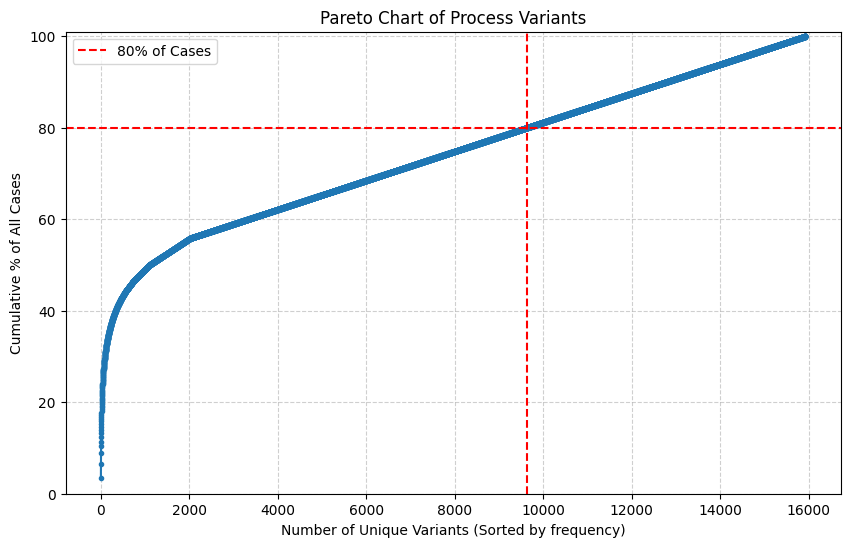

Results:
We have 15930 unique variants in total.
The top 9629 variants (out of 15930) cover 80% of all cases.


In [153]:
import matplotlib.ticker as ticker

total_reps = variantes_df['Repeticiones'].sum()
variantes_df['cum_perc'] = (variantes_df['Repeticiones'].cumsum() / total_reps) * 100

variantes_df['variant_count'] = np.arange(1, len(variantes_df) + 1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(variantes_df['variant_count'], variantes_df['cum_perc'], marker='.')

plt.title('Pareto Chart of Process Variants')
plt.xlabel('Number of Unique Variants (Sorted by frequency)')
plt.ylabel('Cumulative % of All Cases')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 101)

plt.axhline(y=80, color='red', linestyle='--', label='80% of Cases')

variants_for_80_perc = (variantes_df['cum_perc'] <= 80).sum() + 1
plt.axvline(x=variants_for_80_perc, color='red', linestyle='--')

plt.legend()
plt.show()

print(f"Results:")
print(f"We have {len(variantes_df)} unique variants in total.")
print(f"The top {variants_for_80_perc} variants (out of {len(variantes_df)}) cover 80% of all cases.")

### Heuristic Miner

In [148]:
top = 9600
variantes_simplified = pm4py.filter_variants_top_k(log, top)
variantes_simplified.head()
# pm4py.view_heuristics_net(heuristics_net)

Action org:resource            concept:name  EventOrigin  \
0      Created       User_1    A_Create Application  Application   
1  statechange       User_1             A_Submitted  Application   
2      Created       User_1          W_Handle leads     Workflow   
3      Deleted       User_1          W_Handle leads     Workflow   
4      Created       User_1  W_Complete application     Workflow   

                 EventID lifecycle:transition  \
0  Application_652823628             complete   
1   ApplState_1582051990             complete   
2    Workitem_1298499574             schedule   
3    Workitem_1673366067             withdraw   
4    Workitem_1493664571             schedule   

                    time:timestamp           case:LoanGoal  \
0 2016-01-01 09:51:15.304000+00:00  Existing loan takeover   
1 2016-01-01 09:51:15.352000+00:00  Existing loan takeover   
2 2016-01-01 09:51:15.774000+00:00  Existing loan takeover   
3 2016-01-01 09:52:36.392000+00:00  Existing loan takeover   
4 2016-01-01 09:52:36.403000+00:00  Existing loan takeover   

  case:ApplicationType      case:concept:name  case:RequestedAmount  \
0           New credit  Application_652823628               20000.0   
1           New credit  Application_652823628               20000.0   
2           New credit  Application_652823628               20000.0   
3           New credit  Application_652823628               20000.0   
4           New credit  Application_652823628               20000.0   

   FirstWithdrawalAmount  NumberOfTerms Accepted  MonthlyCost Selected  \
0                    NaN            NaN      NaN          NaN      NaN   
1                    NaN            NaN      NaN          NaN      NaN   
2                    NaN            NaN      NaN          NaN      NaN   
3                    NaN            NaN      NaN          NaN      NaN   
4                    NaN            NaN      NaN          NaN      NaN   

   CreditScore  OfferedAmount OfferID  
0          NaN            NaN     NaN  
1          NaN            NaN     NaN  
2          NaN            NaN     NaN  
3          NaN            NaN     NaN  
4          NaN            NaN     NaN

C:\Users\kickb\OneDrive\Escritorio\Praktikum BPM and Process Simulation\Project_Loan_Applications_Analysis\.venv\Lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


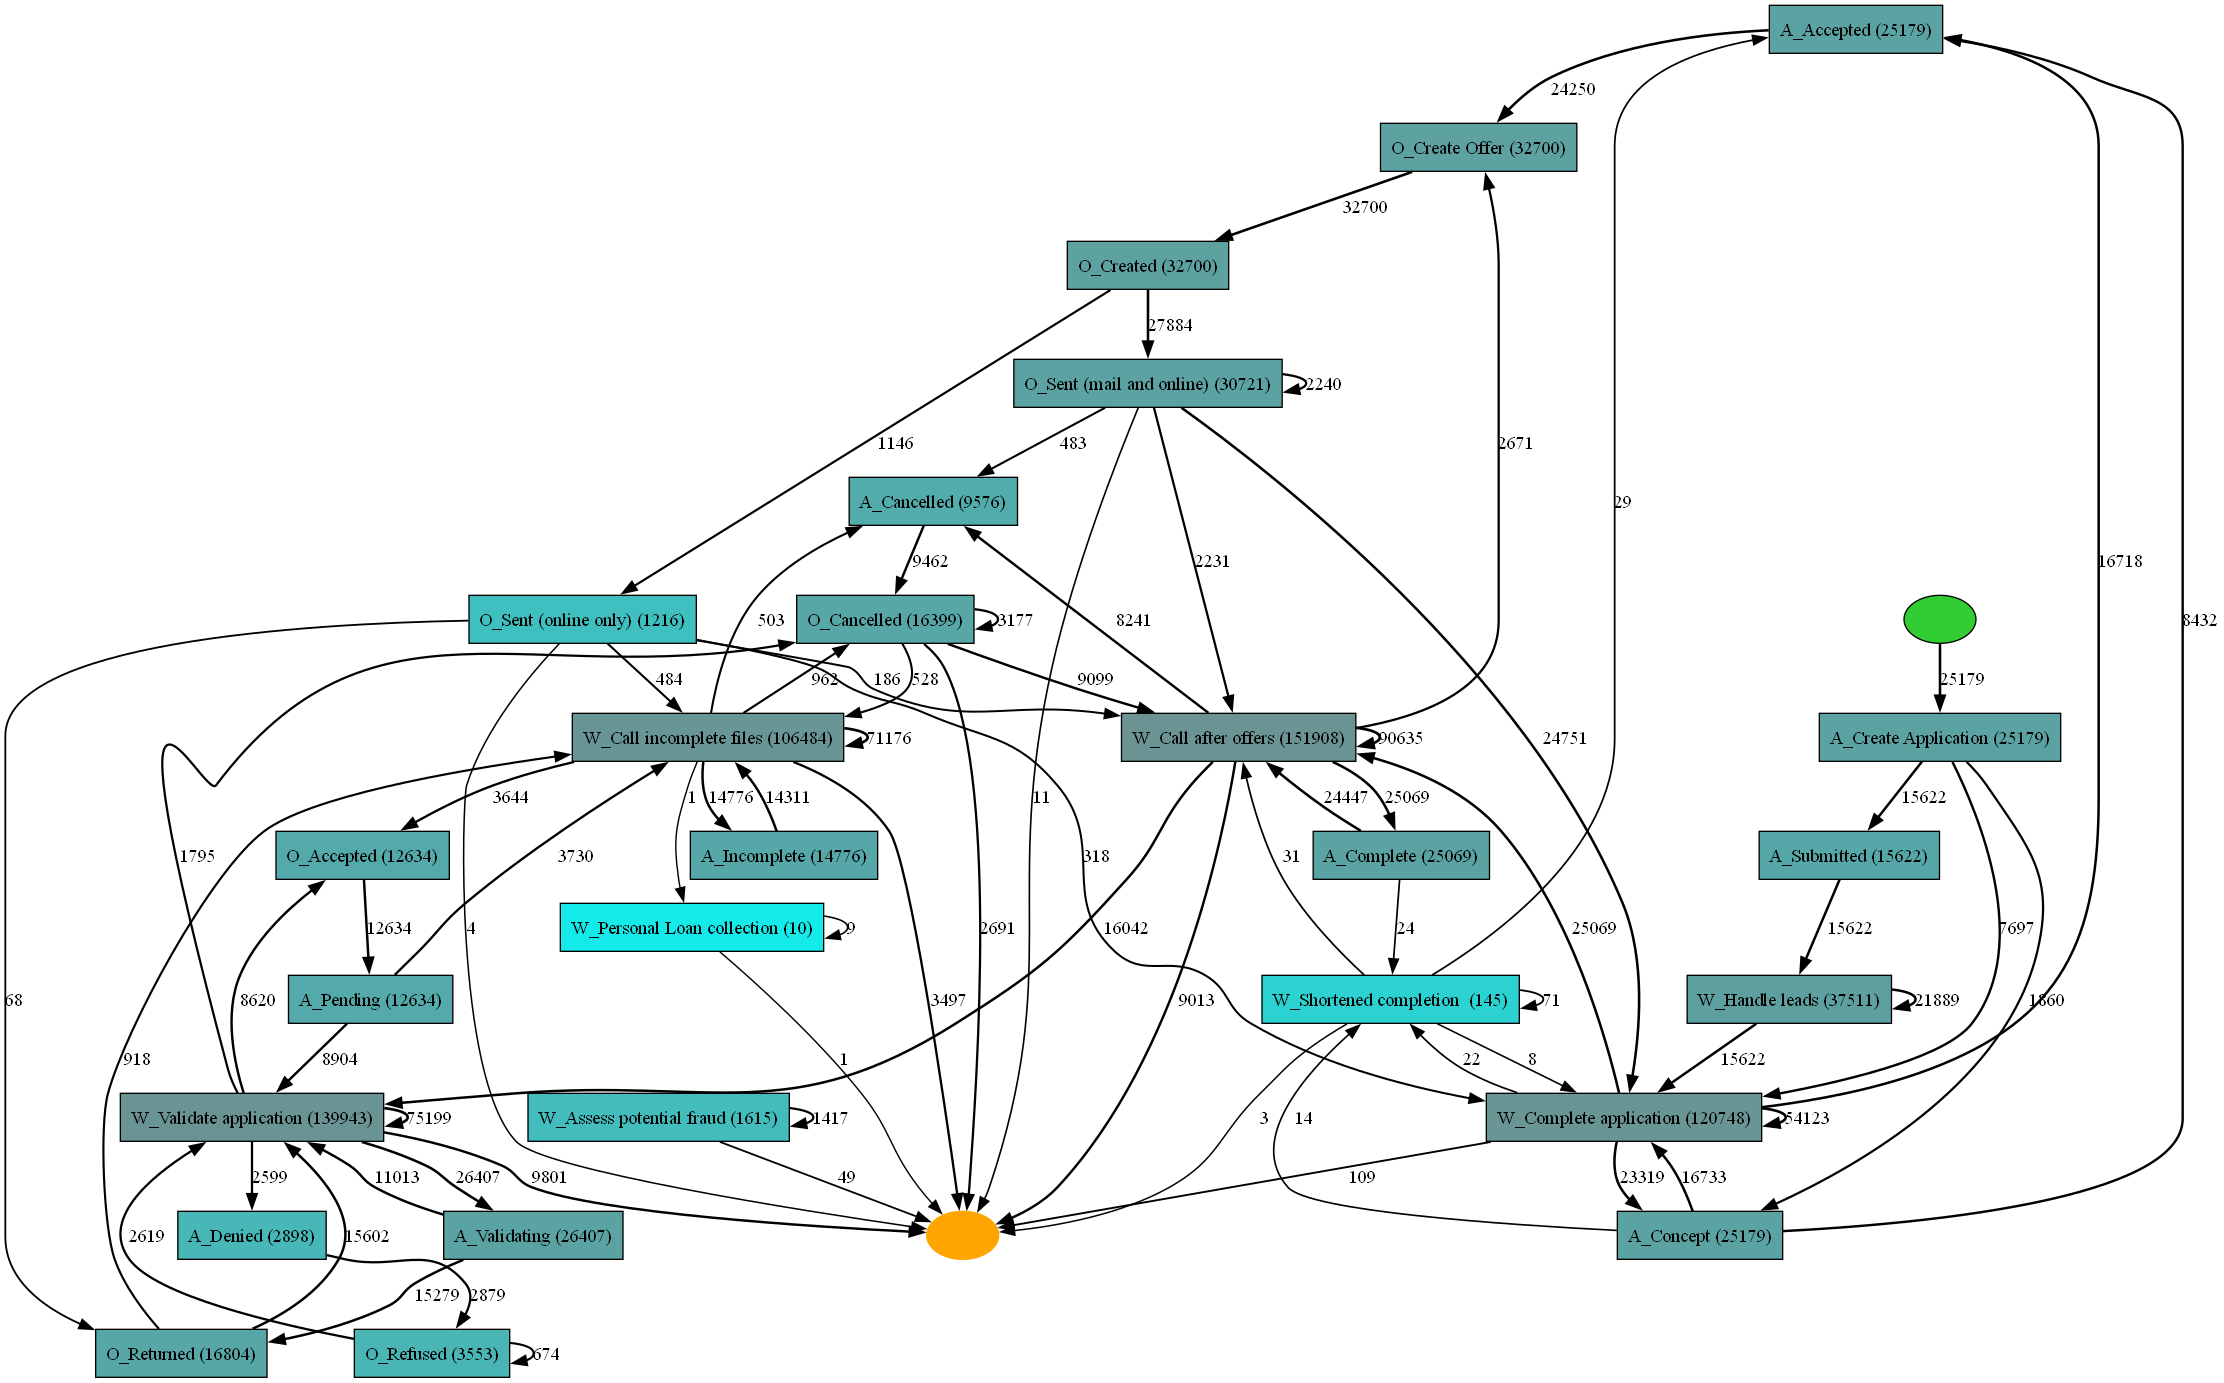

In [149]:
net = pm4py.discover_heuristics_net(variantes_simplified)
pm4py.view_heuristics_net(net)

In [132]:
log_80 = pm4py.algo.filtering.log.variants.variants_filter.filter_log_variants_percentage(log, 0.80)


In [133]:
log_70 = pm4py.algo.filtering.log.variants.variants_filter.filter_log_variants_percentage(log, 0.70)

In [130]:

net80 = pm4py.discover_heuristics_net(log_80, dependency_threshold=0.9)
heuristics_petrinet, im, fm = pm4py.discover_petri_net_heuristics(log_80, dependency_threshold=0.9)

aligning log, completed variants ::   0%|          | 18/15930 [20:56<308:33:59, 69.81s/it]


KeyboardInterrupt: 

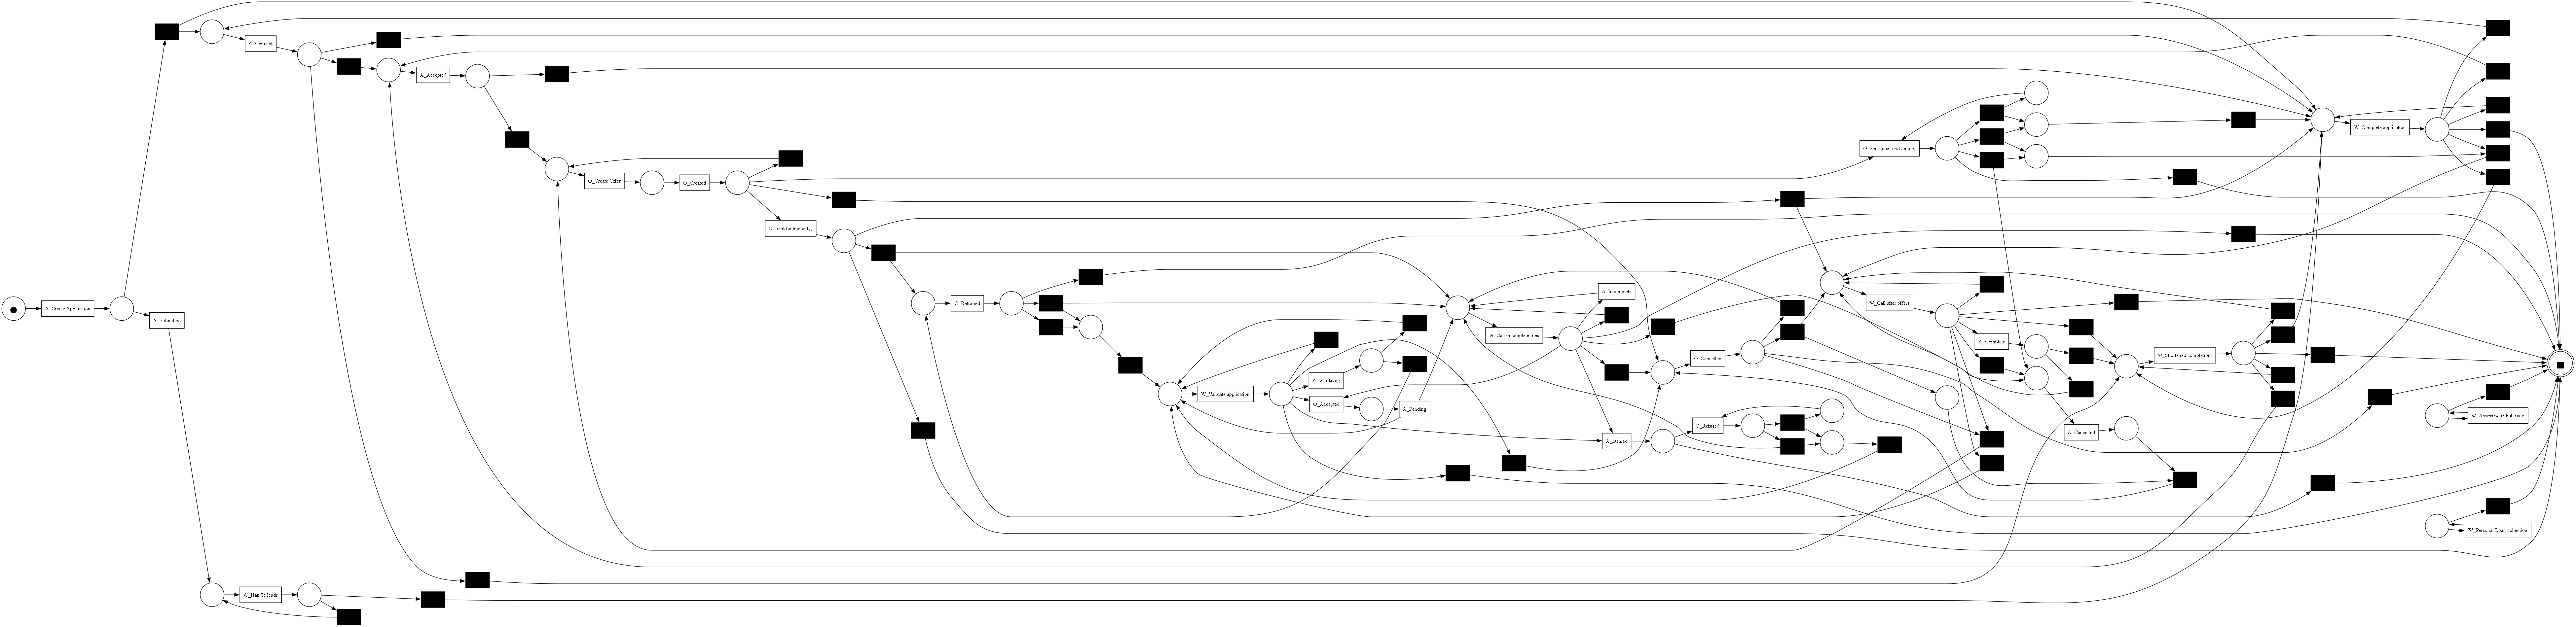

In [122]:
pm4py.view_petri_net(heuristics_petrinet, im, fm)

### Process variances for different LoanGoal values (heuristics miner)

In [4]:
df1 = pm4py.convert_to_dataframe(log)
df1

Action org:resource            concept:name  EventOrigin  \
0            Created       User_1    A_Create Application  Application   
1        statechange       User_1             A_Submitted  Application   
2            Created       User_1          W_Handle leads     Workflow   
3            Deleted       User_1          W_Handle leads     Workflow   
4            Created       User_1  W_Complete application     Workflow   
...              ...          ...                     ...          ...   
1202262      Deleted       User_1     W_Call after offers     Workflow   
1202263      Created       User_1     W_Call after offers     Workflow   
1202264  statechange      User_28             A_Cancelled  Application   
1202265  statechange      User_28             O_Cancelled        Offer   
1202266      Deleted      User_28     W_Call after offers     Workflow   

                       EventID lifecycle:transition  \
0        Application_652823628             complete   
1         ApplState_1582051990             complete   
2          Workitem_1298499574             schedule   
3          Workitem_1673366067             withdraw   
4          Workitem_1493664571             schedule   
...                        ...                  ...   
1202262    Workitem_1817549786            ate_abort   
1202263     Workitem_363876066             schedule   
1202264   ApplState_1869071797             complete   
1202265   OfferState_420066181             complete   
1202266    Workitem_1934044935             withdraw   

                          time:timestamp           case:LoanGoal  \
0       2016-01-01 09:51:15.304000+00:00  Existing loan takeover   
1       2016-01-01 09:51:15.352000+00:00  Existing loan takeover   
2       2016-01-01 09:51:15.774000+00:00  Existing loan takeover   
3       2016-01-01 09:52:36.392000+00:00  Existing loan takeover   
4       2016-01-01 09:52:36.403000+00:00  Existing loan takeover   
...                                  ...                     ...   
1202262 2017-01-06 06:33:02.212000+00:00        Home improvement   
1202263 2017-01-06 06:33:02.221000+00:00        Home improvement   
1202264 2017-01-16 09:51:21.114000+00:00        Home improvement   
1202265 2017-01-16 09:51:21.139000+00:00        Home improvement   
1202266 2017-01-16 09:51:21.146000+00:00        Home improvement   

        case:ApplicationType       case:concept:name  case:RequestedAmount  \
0                 New credit   Application_652823628               20000.0   
1                 New credit   Application_652823628               20000.0   
2                 New credit   Application_652823628               20000.0   
3                 New credit   Application_652823628               20000.0   
4                 New credit   Application_652823628               20000.0   
...                      ...                     ...                   ...   
1202262           New credit  Application_1350494635               20000.0   
1202263           New credit  Application_1350494635               20000.0   
1202264           New credit  Application_1350494635               20000.0   
1202265           New credit  Application_1350494635               20000.0   
1202266           New credit  Application_1350494635               20000.0   

         FirstWithdrawalAmount  NumberOfTerms Accepted  MonthlyCost Selected  \
0                          NaN            NaN      NaN          NaN      NaN   
1                          NaN            NaN      NaN          NaN      NaN   
2                          NaN            NaN      NaN          NaN      NaN   
3                          NaN            NaN      NaN          NaN      NaN   
4                          NaN            NaN      NaN          NaN      NaN   
...                        ...            ...      ...          ...      ...   
1202262                    NaN            NaN      NaN          NaN      NaN   
1202263                    NaN            NaN      NaN          NaN   

In [5]:
# Car
car_df = df1[df1['case:LoanGoal'] == 'Car']
car_log = pm4py.convert_to_event_log(car_df)
variants_car = pm4py.get_variants(car_log)

car_net = pm4py.discover_heuristics_net(car_log)

print("The number of variances in car applications is: ", len(variants_car))



The number of variances in car applications is:  5069


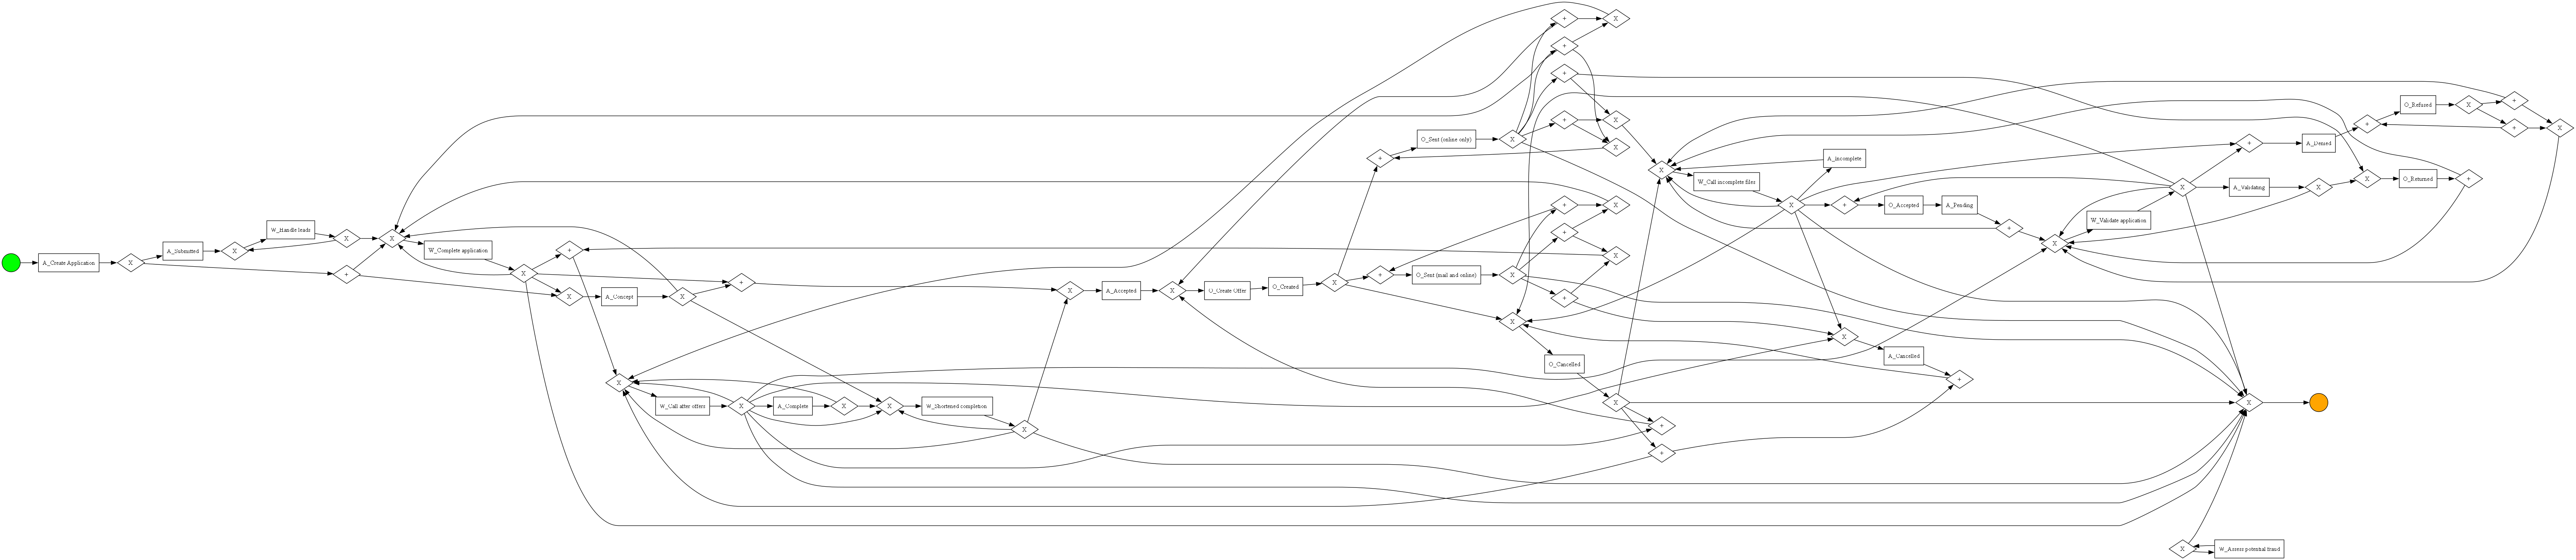

In [11]:
#pm4py.view_heuristics_net(car_net)
bmpn_car = pm4py.convert_to_bpmn(car_net)
pm4py.view_bpmn(bmpn_car)

In [214]:
# home improvement
hi_df = df1[df1['case:LoanGoal'] == 'Home improvement']
hi_log = pm4py.convert_to_event_log(hi_df)
variants_hi = pm4py.get_variants(hi_log)

hi_net = pm4py.discover_heuristics_net(hi_log)

print("The number of variances in Home improment is: ", len(variants_hi))


The number of variances in Home improment is:  4535


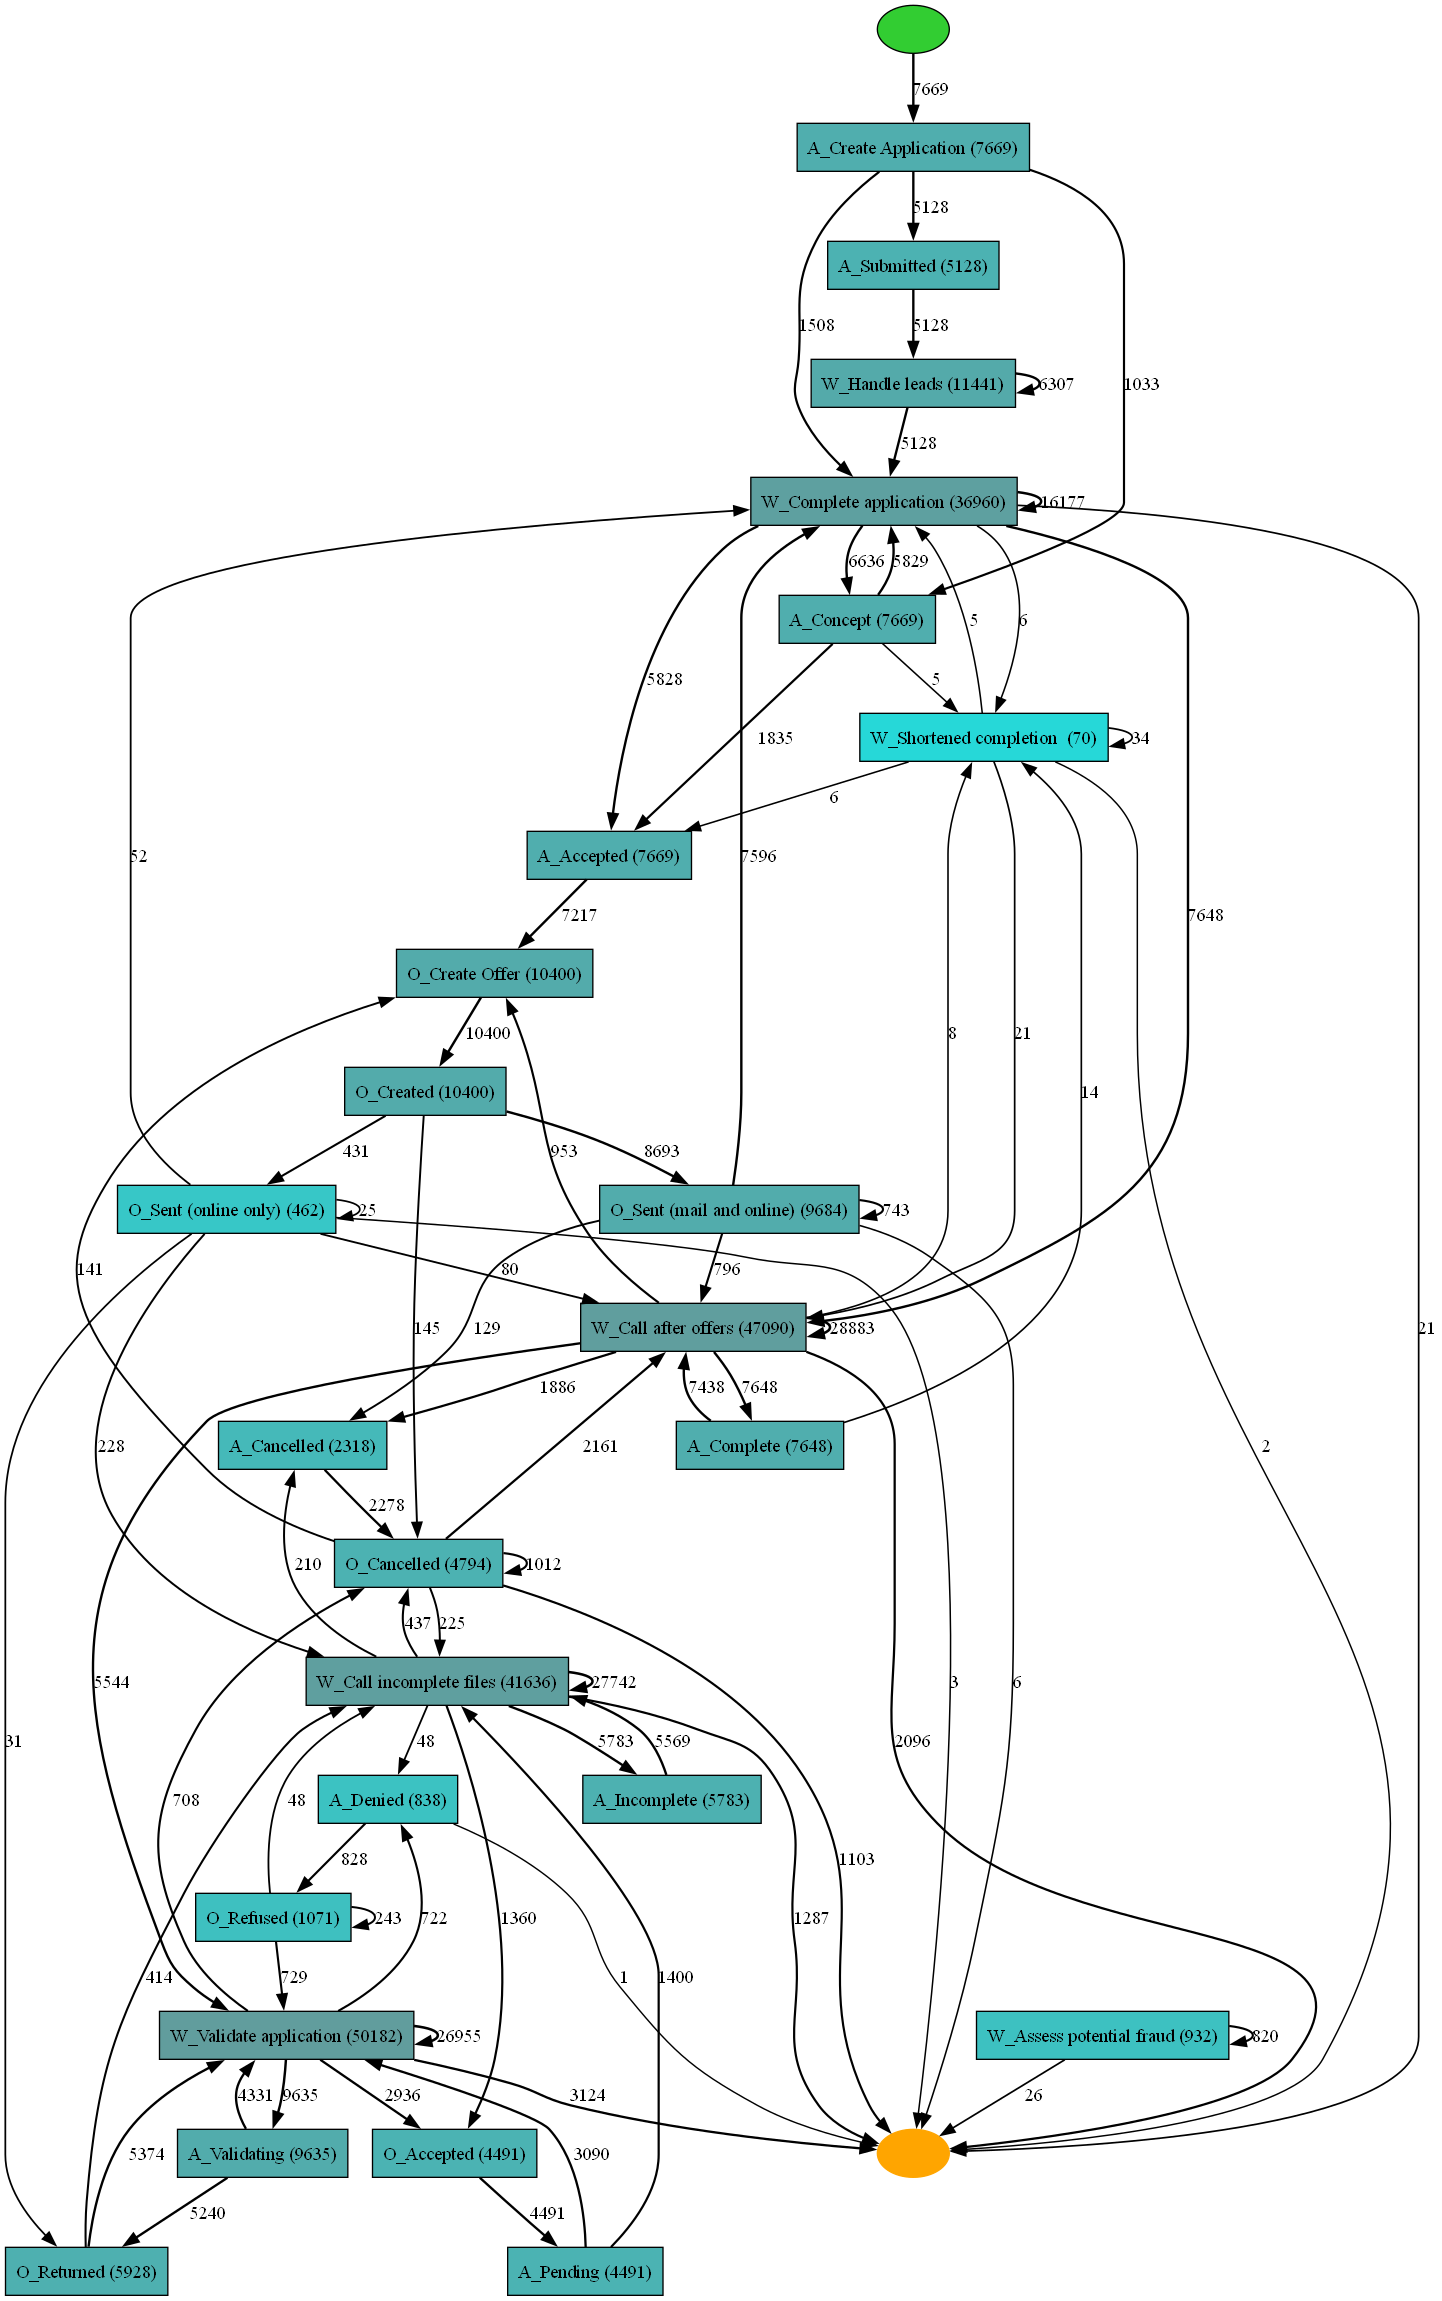

In [216]:
pm4py.view_heuristics_net(hi_net)

In [13]:
# net for motorcycle
motorcycle_df = df1[df1['case:LoanGoal'] == 'Motorcycle']
motorcycle_log = pm4py.convert_to_event_log(motorcycle_df)
variants_motorcycle = pm4py.get_variants(motorcycle_log)

motorcycle_net = pm4py.discover_heuristics_net(motorcycle_log)

print("The number of variances in Motorcycle is: ", len(variants_motorcycle))

The number of variances in Motorcycle is:  221


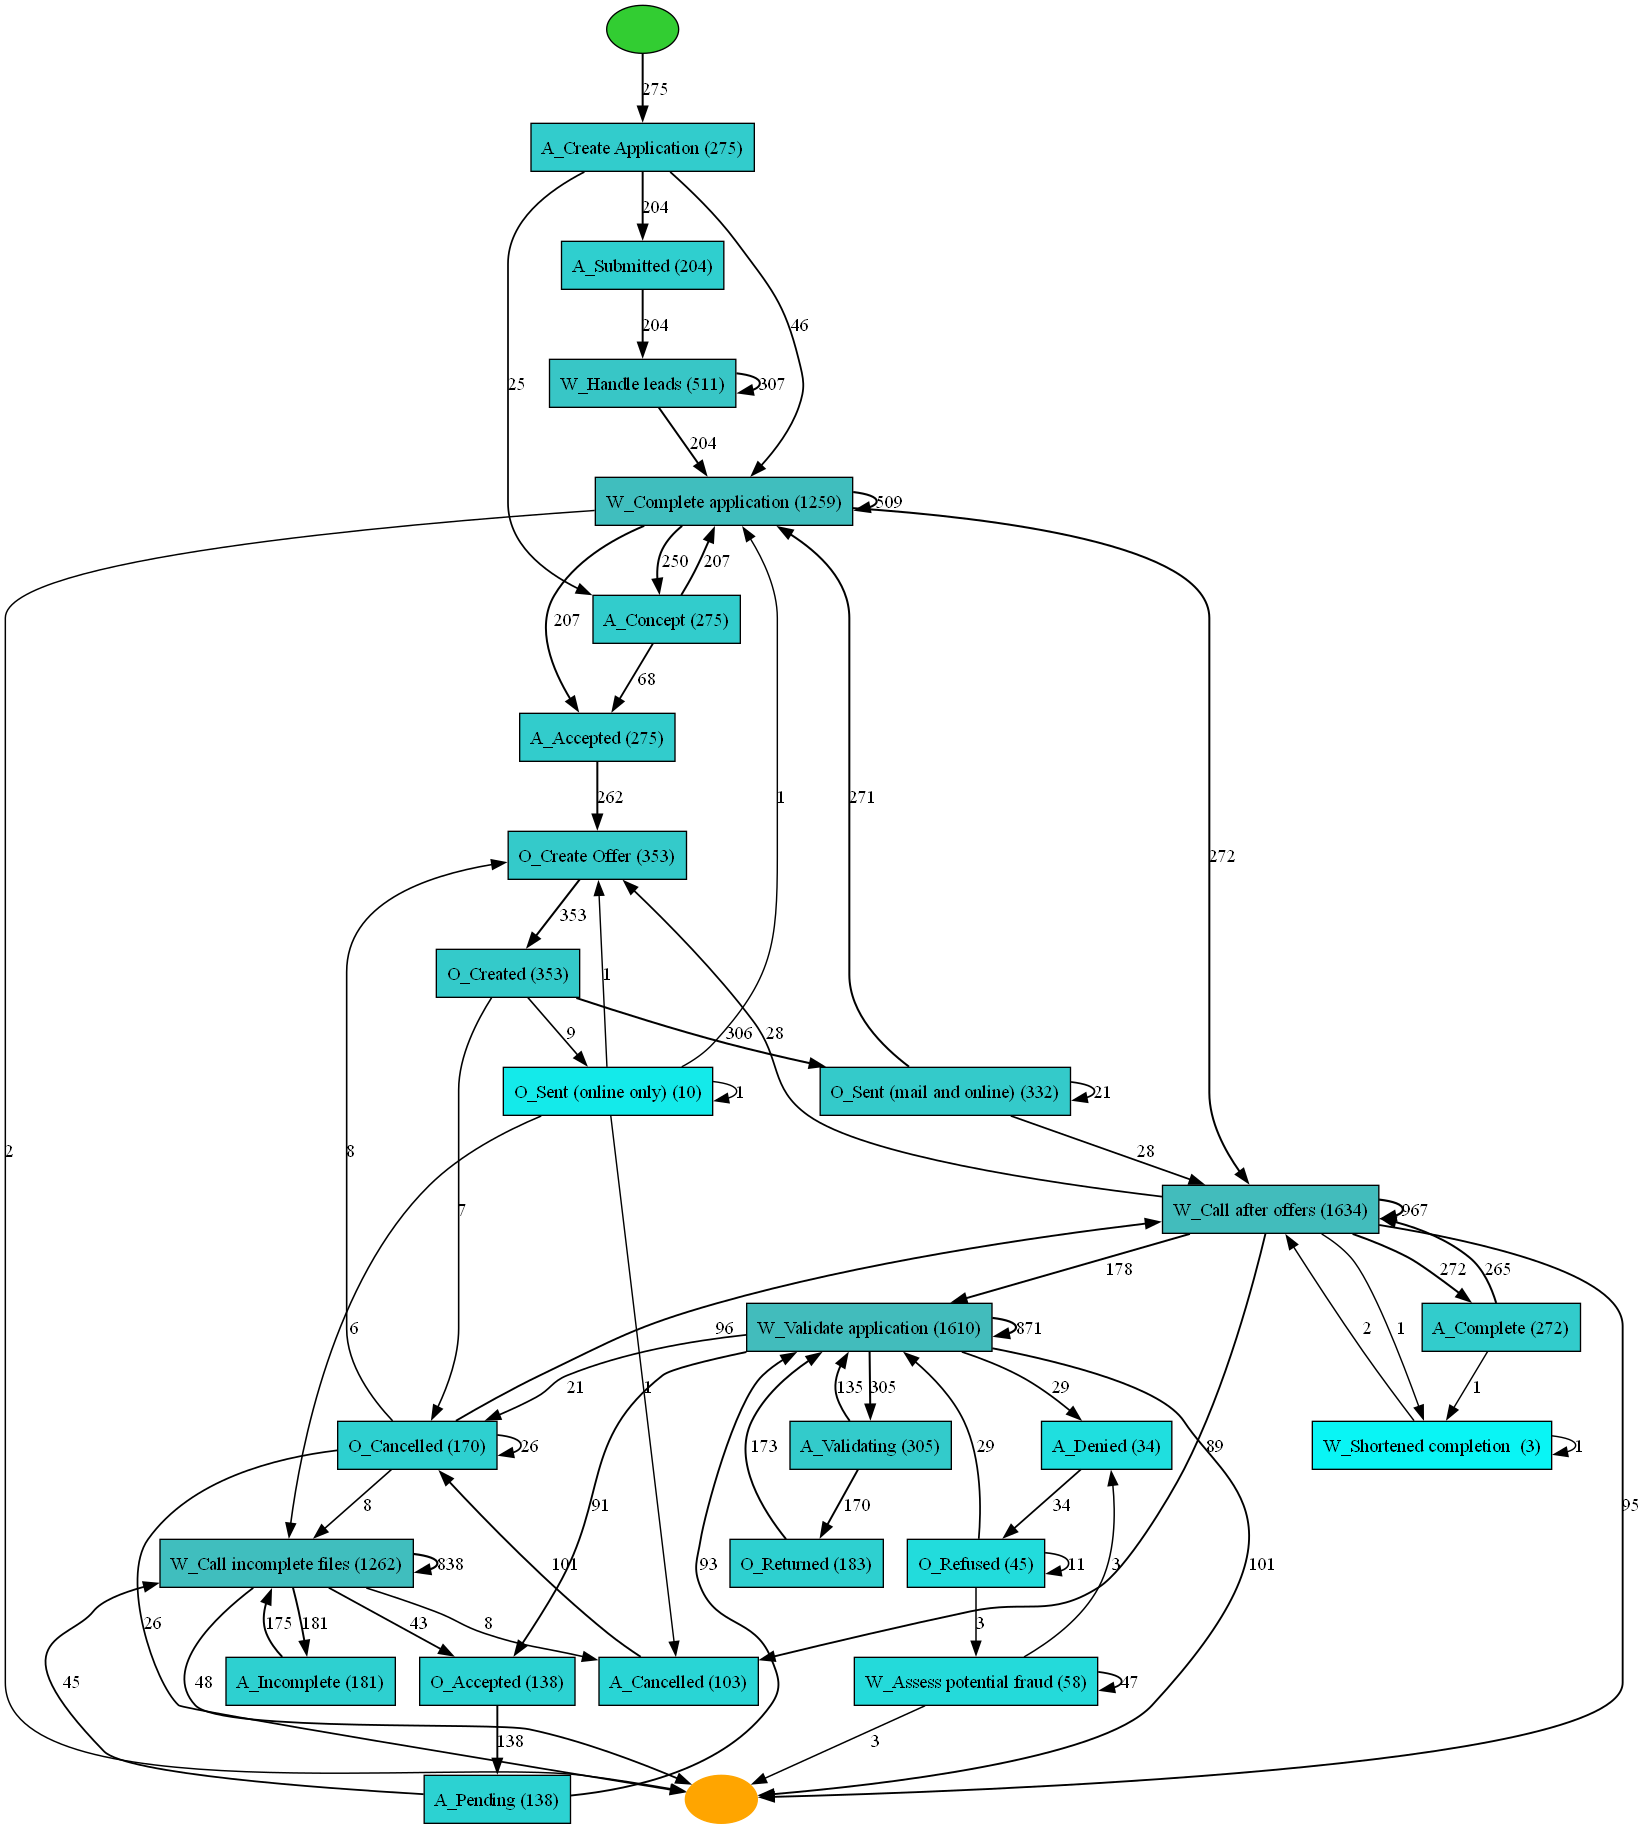

In [14]:
pm4py.view_heuristics_net(motorcycle_net)

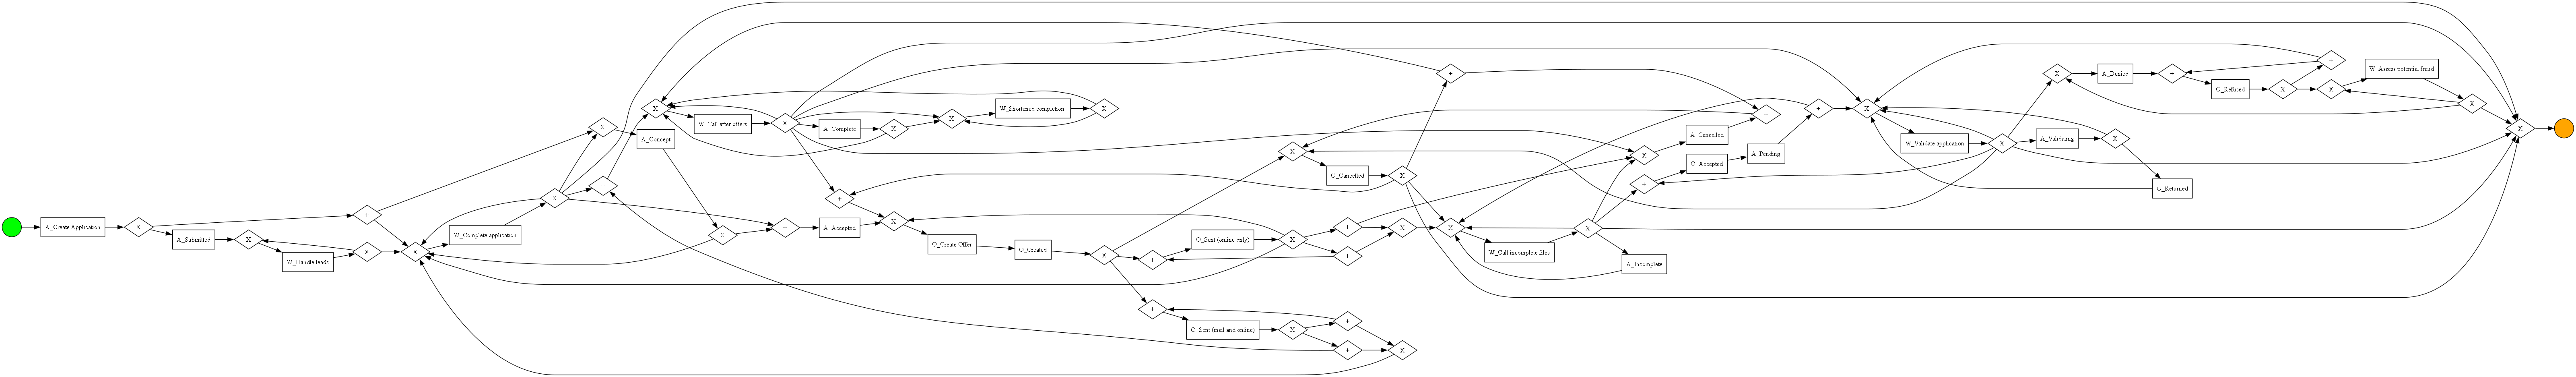

In [15]:
bmpn_motorcycle = pm4py.convert_to_bpmn(motorcycle_net)
pm4py.view_bpmn(bmpn_motorcycle)

### Alpha miner

In [74]:
alpha_net, marking, final_marking = pm4py.algo.discovery.alpha.algorithm.apply(log)

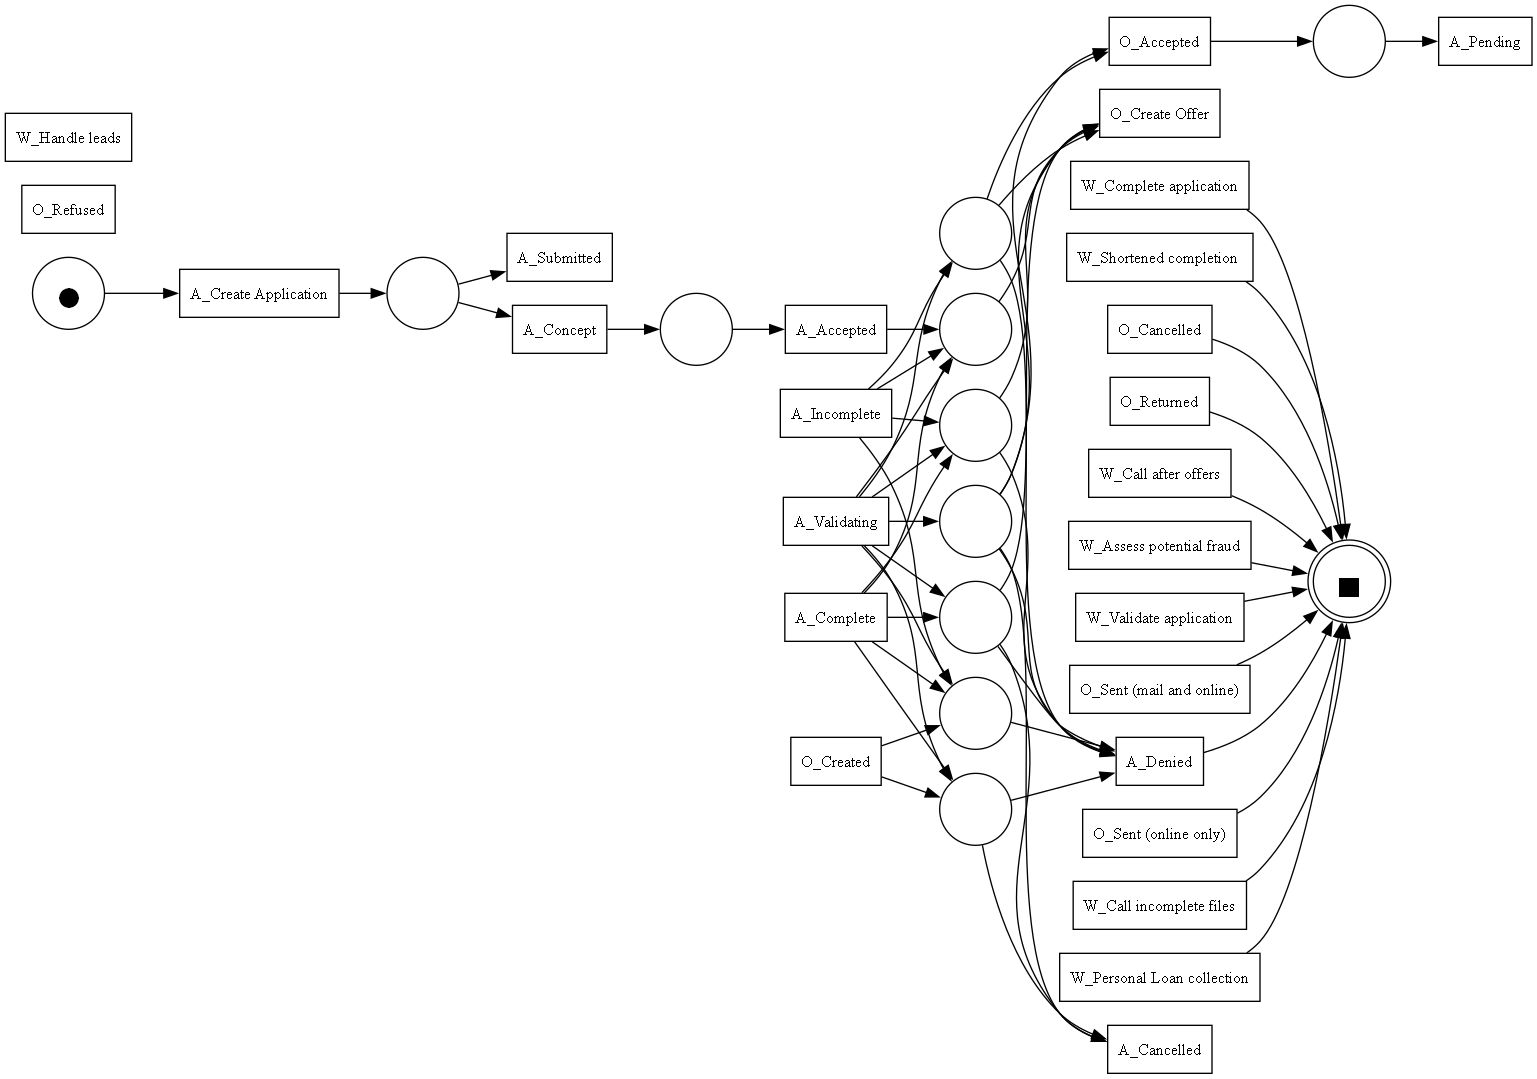

In [75]:
pm4py.view_petri_net(alpha_net, marking, final_marking)

In [92]:
# Conformance checking FITNESS with token-based approach
tbr_output = []
tbr_output = pm4py.conformance_diagnostics_token_based_replay(log, alpha_net, marking, final_marking)


replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [00:33<00:00, 480.10it/s]


In [93]:
tbr_diagnostics = pm4py.algo.conformance.tokenreplay.algorithm.get_diagnostics_dataframe(log, tbr_output)


In [109]:
print(tbr_diagnostics['trace_fitness'].mean())

0.40385723651956235


-> No case has a true fit with the model

In [100]:
# alignment approach
alignment_output = pm4py.conformance_diagnostics_alignments(log, alpha_net, marking, final_marking)

aligning log, completed variants :: 100%|██████████| 15930/15930 [19:33<00:00, 13.57it/s]


In [101]:
alignment_diagnostics = pm4py.algo.conformance.alignments.petri_net.algorithm.get_diagnostics_dataframe(log, alignment_output)

In [108]:
print(alignment_diagnostics['fitness'].mean())

0.19043267096912012


### Inductive Miner

In [128]:
inductive_net, initial_marking1, final_marking1 = pm4py.discover_petri_net_inductive(log_80, noise_threshold=0.2)

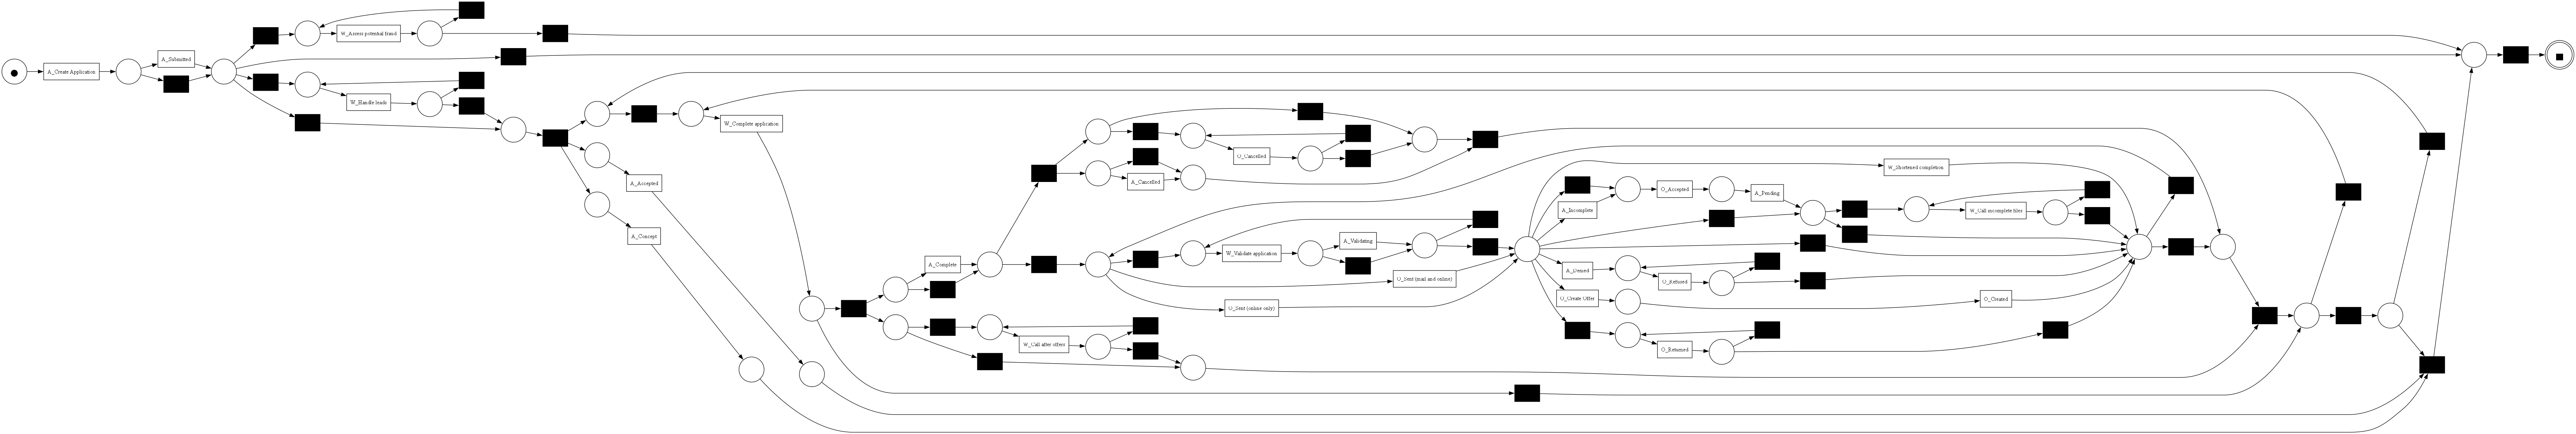

In [129]:
pm4py.view_petri_net(inductive_net, initial_marking1, final_marking1)

In [134]:
inductive_net70, initial_marking2, final_marking2 = pm4py.discover_petri_net_inductive(log_70, noise_threshold=0.2)

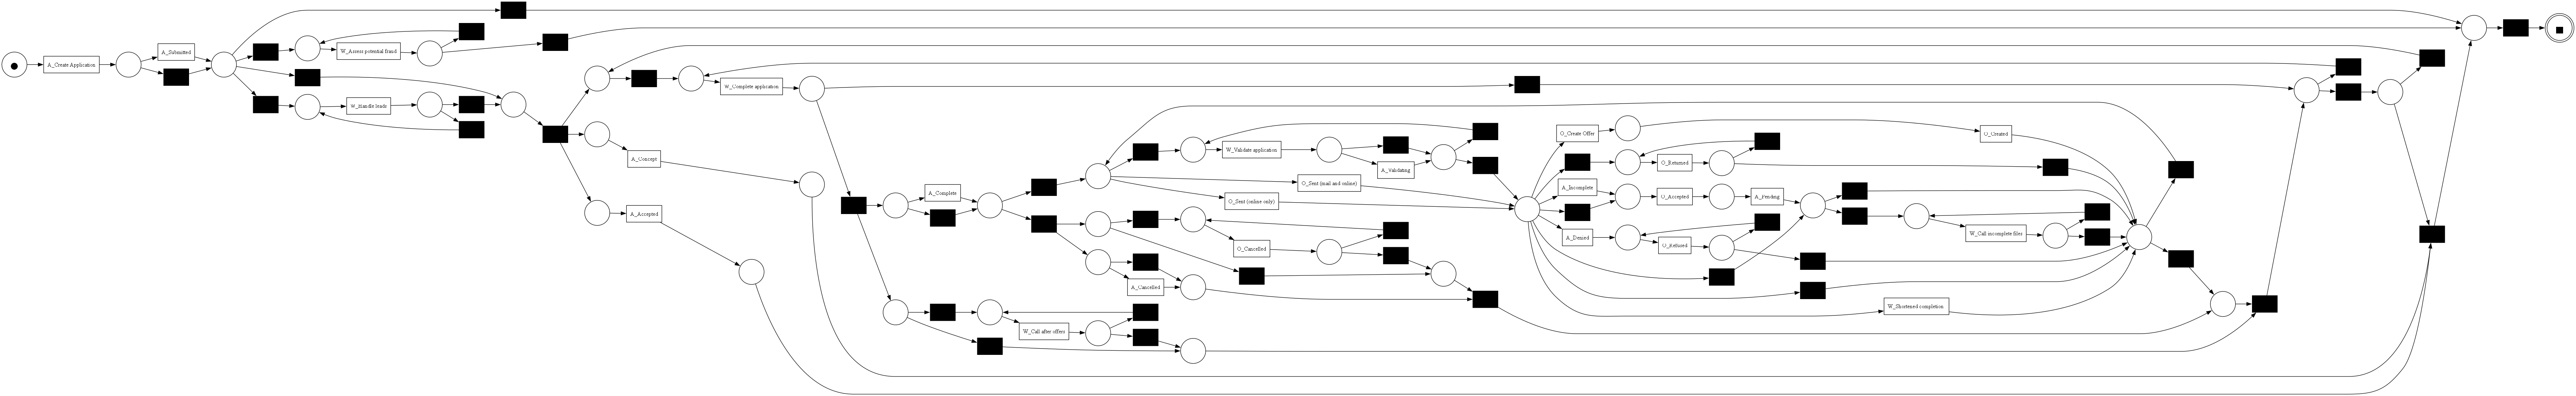

In [135]:
pm4py.view_petri_net(inductive_net70, initial_marking2, final_marking2)